In [48]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [52]:
daily_category_sales = pd.read_csv('../data/daily_category_sales.csv', header=[0,1], index_col=0)
quantity_data = daily_category_sales['quantity_sum'].copy()
print(quantity_data.isna().sum())
quantity_data.fillna(0, inplace=True) # use zero to replace NaN

category_name
Aquatic Roots and Tubers    0
Cauliflower                 0
Chili Peppers               0
Edible Mushrooms            0
Leafy Greens                0
Solanaceous Vegetables      0
dtype: int64


# 1. LSTM for sales volume prediction

## Build dataset
### Use sales quantity of last 30 days to predict sales quantity of next 7 days

In [ ]:
lag = 30
X = np.array([np.array(quantity_data.iloc[idx-lag:idx,]) for idx in range(lag, quantity_data.shape[0]-7, 1)])
y = np.array([np.array(quantity_data.iloc[idx:idx+7,]) for idx in range(lag, quantity_data.shape[0]-7, 1)])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
print(X_train_tensor.shape, y_train_tensor.shape)
# (batch, seq_len, input_size)

## Configure & initialize model

In [15]:
class MultiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, output_seq_len):
        super(MultiLSTM, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size*output_seq_len)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        output = output.view(output.size(0), output_seq_len, output_size)  # 将输出变形为 (batch_size, m, 7)
        return output


In [16]:
# Initialize the LSTM model
input_size = 6
hidden_size = 256
num_layers = 2
output_size = 6
output_seq_len = 7

model = MultiLSTM(input_size, hidden_size, output_size, output_seq_len).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

MultiLSTM(
  (lstm): LSTM(6, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=42, bias=True)
)


## Training

In [ ]:
# load data in batches
dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 128
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
n_batch = math.ceil(X_train_tensor.shape[0] / batch_size)

train_loss, val_loss = [], [] 
# train
num_epochs = 2000
for epoch in range(num_epochs):
    epoch_train_loss = 0
    model.train()
    for X_batch, y_batch in data_loader:
        # forward pass
        outputs = model(X_batch)

        # Compute the RMSE loss
        loss = torch.sqrt(criterion(outputs, y_batch))

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() / n_batch
    
    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        epoch_val_loss = torch.sqrt(criterion(val_outputs, y_val_tensor))

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss.item())

    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_loss, label='Train Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('RMSE Loss', fontsize=16)
ax.set_title('Train and Validation Loss',fontsize=20)
ax.set_ylim(0, 110)
ax.legend(fontsize=16)
ax.grid(True)
plt.show()

In [ ]:
fig.savefig('../figures/lstm1_train_val_loss.png',dpi=600)

In [ ]:
model_config = {
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "output_size": output_size,
    "fc_size": 24
}

with open('../model/lstm1_config.json', 'w') as f:
    json.dump(model_config, f)

torch.save(model.state_dict(),'../model/lstm1_for_category_sales_volume.pt')

## Model Metrics: R-square & RMSE

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
y_pred = model(X_val_tensor).cpu().detach().numpy()
y_true = y_val_tensor.cpu().detach().numpy()
print(f'R-square: {r2_score(y_true.reshape(-1), y_pred.reshape(-1)):.4f};\t RMSE: {torch.sqrt(criterion(val_outputs, y_val_tensor)).item():.4f}' )

### TODO: Visualize prediction of each category

In [ ]:
# load model weights
model = MultiLSTM(input_size, hidden_size, output_size, output_seq_len).to(device)
model.load_state_dict(torch.load('../model/lstm1_for_category_sales_volume.pt'))

In [ ]:
X_tensor = torch.FloatTensor(X).to(device)
y_tensor = torch.FloatTensor(y).to(device)

model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_tensor)

y_true = y_tensor[:,0,:].cpu().detach().numpy().T 
y_pred = y_pred_tensor[:,0,:].cpu().detach().numpy().T

math.sqrt(mean_squared_error(y_true.reshape(-1), y_pred.reshape(-1)))

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y_true[0].reshape(-1), label='True')
ax.plot(y_pred[0].reshape(-1), label='Predicted')

# 2. LSTM for wholesale price prediction

In [66]:
# average wholesale price
price_data = daily_category_sales['cost_sum'] / daily_category_sales['quantity_sum']
price_data.fillna(0, inplace=True) 

lag = 30
X = np.array([np.array(price_data.iloc[idx-lag:idx,]) for idx in range(lag, price_data.shape[0]-7, 1)])
y = np.array([np.array(price_data.iloc[idx:idx+7,]) for idx in range(lag, price_data.shape[0]-7, 1)])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
print(X_train_tensor.shape, y_train_tensor.shape)
# (batch, seq_len, input_size)

torch.Size([733, 30, 6]) torch.Size([733, 7, 6])


In [43]:
model = MultiLSTM(input_size, hidden_size, output_size, output_seq_len).to(device)
print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

MultiLSTM(
  (lstm): LSTM(6, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=42, bias=True)
)


In [44]:
# load data in batches
dataset = TensorDataset(X_train_tensor, y_train_tensor)
batch_size = 128
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
n_batch = math.ceil(X_train_tensor.shape[0] / batch_size)

train_loss, val_loss = [], [] 
# train
num_epochs = 1000
for epoch in range(num_epochs):
    epoch_train_loss = 0
    model.train()
    for X_batch, y_batch in data_loader:
        # forward pass
        outputs = model(X_batch)

        # Compute the RMSE loss
        loss = torch.sqrt(criterion(outputs, y_batch))

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item() / n_batch
    
    # validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        epoch_val_loss = torch.sqrt(criterion(val_outputs, y_val_tensor))

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss.item())

    if (epoch+1) % 50 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')


Epoch [1/1000], Train Loss: 5.5720, Validation Loss: 5.0170
Epoch [50/1000], Train Loss: 1.3070, Validation Loss: 1.3013
Epoch [100/1000], Train Loss: 0.9475, Validation Loss: 0.9813
Epoch [150/1000], Train Loss: 0.8675, Validation Loss: 0.9014
Epoch [200/1000], Train Loss: 0.8039, Validation Loss: 0.8240
Epoch [250/1000], Train Loss: 0.7494, Validation Loss: 0.7889
Epoch [300/1000], Train Loss: 0.7205, Validation Loss: 0.7486
Epoch [350/1000], Train Loss: 0.7112, Validation Loss: 0.7424
Epoch [400/1000], Train Loss: 0.6716, Validation Loss: 0.7041
Epoch [450/1000], Train Loss: 0.6618, Validation Loss: 0.7024
Epoch [500/1000], Train Loss: 0.6522, Validation Loss: 0.6923
Epoch [550/1000], Train Loss: 0.6453, Validation Loss: 0.6992
Epoch [600/1000], Train Loss: 0.6128, Validation Loss: 0.6832
Epoch [650/1000], Train Loss: 0.6013, Validation Loss: 0.6767
Epoch [700/1000], Train Loss: 0.5858, Validation Loss: 0.6680
Epoch [750/1000], Train Loss: 0.5849, Validation Loss: 0.6735
Epoch [800/

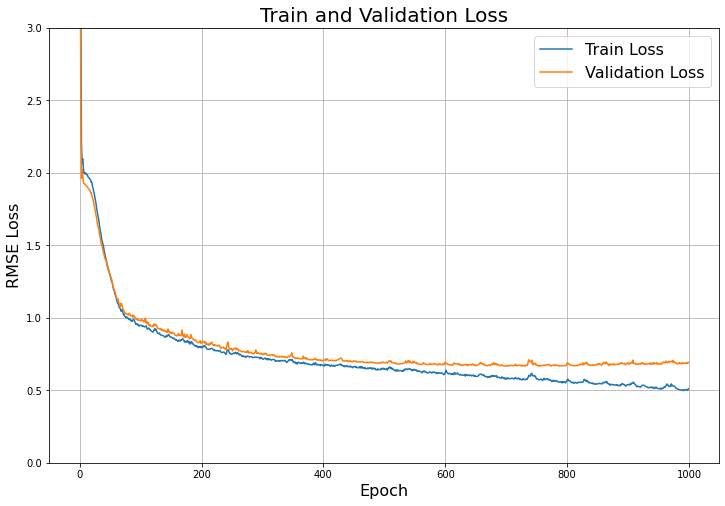

In [45]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_loss, label='Train Loss')
ax.plot(val_loss, label='Validation Loss')
ax.set_xlabel('Epoch', fontsize=16)
ax.set_ylabel('RMSE Loss', fontsize=16)
ax.set_title('Train and Validation Loss',fontsize=20)
ax.set_ylim(0, 3)
ax.legend(fontsize=16)
ax.grid(True)
plt.show()

In [46]:
fig.savefig('../figures/lstm2_train_val_loss.png',dpi=600)

In [47]:
model_config = {
    "input_size": input_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "output_size": output_size,
    "fc_size": 24
}

with open('../model/lstm2_config.json', 'w') as f:
    json.dump(model_config, f)

torch.save(model.state_dict(),'../model/lstm2_for_category_wholesale_price.pt')

# 3. Make predictions for the following week

In [56]:
lstm1 = MultiLSTM(input_size, hidden_size, output_size, output_seq_len).to(device)
lstm1.load_state_dict(torch.load('../model/lstm1_for_category_sales_volume.pt'))
lstm2 = MultiLSTM(input_size, hidden_size, output_size, output_seq_len).to(device)
lstm2.load_state_dict(torch.load('../model/lstm2_for_category_wholesale_price.pt'))

<All keys matched successfully>

In [67]:
pred_X1 = quantity_data.iloc[-lag:,].values.reshape(1, lag, input_size)
pred_X1_tensor = torch.FloatTensor(pred_X1).to(device)

pred_X2 = price_data.iloc[-lag:,].values.reshape(1, lag, input_size)
pred_X2_tensor = torch.FloatTensor(pred_X2).to(device)

print(pred_X1_tensor.shape, pred_X2_tensor.shape)

torch.Size([1, 30, 6]) torch.Size([1, 30, 6])


In [87]:
with torch.no_grad():
    pred_y1 = lstm1(pred_X1_tensor)
    pred_y2 = lstm2(pred_X2_tensor)

pred_y1 = pred_y1.cpu().detach().numpy()
pred_y2 = pred_y2.cpu().detach().numpy()
pred_y1 = np.squeeze(pred_y1)
pred_y2 = np.squeeze(pred_y2)


In [88]:
np.save('../results/pred_sale_volume.npy', pred_y1)
np.save('../results/pred_wholesale_price.npy', pred_y2)